## University of Washington: Machine Learning and Statistics 

# Lecture 2:  Regression (basis functions, regularization, cross-validation)

Andrew Connolly and Stephen Portillo

##### Resources for this notebook include:
- [Textbook](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy) Chapter 8. 

This notebook is developed based on material from A. Connolly, Z. Ivezic, M. Juric, S. Portillo, G. Richards, B. Sipocz, J. VanderPlas, D. Hogg, and many others.

The notebook and assoociated material are available from [github](https://github.com/uw-astro/astr-598a-win22).



<a id='toc'></a>

## This notebook includes:

[Linear Basis Function Regression](#basis) 


[Regularization](#regularization) 


[Cross Validation](#cross-validation) 


[Non-linear Regression with MCMC](#mcmc) 

## Linear Basis Function Regression <a id='basis'></a>
[Go to top](#toc)

We don't have to use only polynomials ($x$, $x^2$, $x^3$, etc) - we can use any function f(x)
and still have a linear problem (in unknown coefficients, $a_i$), e.g.

$$  y(x) = \sum_i^N a_i \, f_i(x) $$

### Example: 

Let's express a complicated $y(x)$, such a spectrum of Vega, as sum of 
Gaussian functions: $ f_i(x) = N(x|\mu_i, \sigma)$, where $\mu_i$ are defined on a grid and $\sigma$ is constant and chosen depending on the intrinsic problem resolution.

Why? Because then we can do convolution with another function (which can be also expressed
as a series of Gaussian functions) analytically! 

### NOTE: We  suppress warnings for the packages (this is not recommended) 

In [5]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib
matplotlib.rc('text', usetex=False)
import seaborn as sns
from scipy import optimize

from astroML.linear_model import TLS_logL
from astroML.datasets import fetch_vega_spectrum
from astroML.plotting import setup_text_plots
from astroML.plotting.mcmc import convert_to_stdev
setup_text_plots(fontsize=8, usetex=True)
# random seed 
np.random.seed(42)

In [6]:
import warnings
warnings.filterwarnings("ignore")

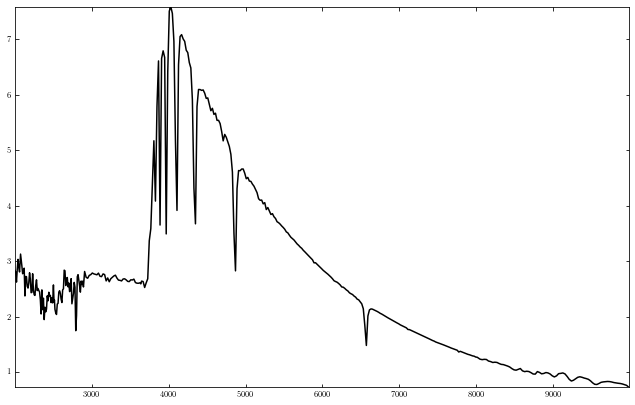

In [7]:
from astroML.datasets import fetch_vega_spectrum
# Fetch the data
x, y = fetch_vega_spectrum()
# truncate the spectrum
mask = (x >= 2000) & (x < 10000)
x = x[mask]
y = y[mask]*1.0e14

# a quick plot 
plt.figure(figsize=(11, 7))
plt.plot(x, y, '-k', label='input spectrum')
plt.show()

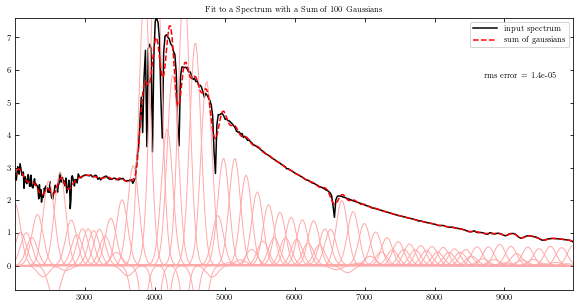

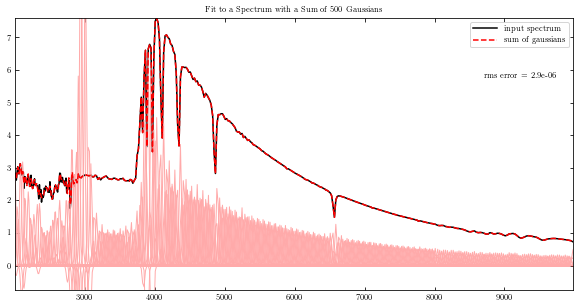

In [23]:
from astroML.sum_of_norms import sum_of_norms, norm
for n_gaussians in (100, 500):

    # compute the best-fit linear combination
    # the actual astroML code can be found in file 
    #    $astroMLdir/astroML/sum_of_norms.py
    w_best, rms, locs, widths = sum_of_norms(x, y, n_gaussians,
                                             spacing='linear',
                                             full_output=True)

    norms = w_best * norm(x[:, None], locs, widths)

    # plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, '-k', label='input spectrum')
    ylim = plt.ylim()

    plt.plot(x, norms, ls='-', c='#FFAAAA', lw=1)
    plt.plot(x, norms.sum(1), '--r', label='sum of gaussians')

    plt.ylim(-0.1 * ylim[1], ylim[1])
    plt.legend(loc=0)
    plt.text(0.97, 0.8,
             "rms error = %.2g" % rms,
             ha='right', va='top', transform=plt.gca().transAxes)
    plt.title("Fit to a Spectrum with a Sum of %i Gaussians" % n_gaussians)

plt.show()


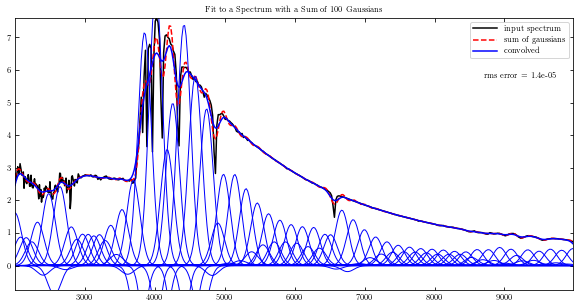

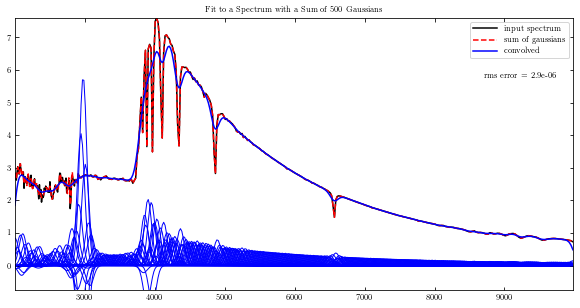

In [25]:
for n_gaussians in (100, 500):

    # compute the best-fit linear combination
    w_best, rms, locs, widths = sum_of_norms(x, y, n_gaussians,
                                             spacing='linear',
                                             full_output=True)

    norms = w_best * norm(x[:, None], locs, widths)

    # plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, '-k', label='input spectrum')
    ylim = plt.ylim()

    # plt.plot(x, norms, ls='-', c='#FFAAAA', lw=1)
    plt.plot(x, norms.sum(1), '--r', label='sum of gaussians')

    
    # convolve with a gaussian instrumental resolution (width = 50)
    widths2 = np.sqrt(widths**2 + 50**2)
    norms2 = w_best * norm(x[:, None], locs, widths2)
    plt.plot(x, norms2, ls='-', c='blue', lw=1)
    plt.plot(x, norms2.sum(1), '-b', label='convolved')

    
    plt.ylim(-0.1 * ylim[1], ylim[1])
    plt.legend(loc=0)
    plt.text(0.97, 0.8,
             "rms error = %.2g" % rms,
             ha='right', va='top', transform=plt.gca().transAxes)
    plt.title("Fit to a Spectrum with a Sum of %i Gaussians" % n_gaussians)

plt.show()


### Using astroML to fit a set of basis functions

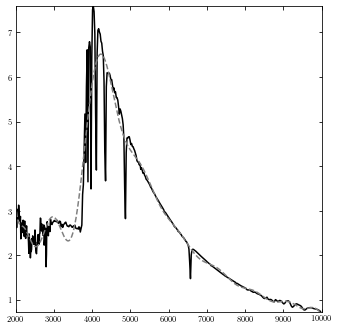

In [22]:
from astroML.linear_model import (LinearRegression, PolynomialRegression,
                                  BasisFunctionRegression, NadarayaWatson)
# Define our classifiers
nbasis=20

basis_mu = np.linspace(2000, 10000, nbasis)[:, None]
basis_sigma = 3 * (basis_mu[1] - basis_mu[0])

clf = BasisFunctionRegression('gaussian', mu=basis_mu, sigma=basis_sigma)
clf.fit(x[:, None], y, y_error=1)

x_sample = np.linspace(2000, 10000, 1000)
y_sample_fit = clf.predict(x_sample[:, None])
y_fit = clf.predict(x[:, None])


fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    hspace=0.05, wspace=0.05)
ax = fig.add_subplot(111)

ax.plot(x, y, '-k')
ax.plot(x_sample, y_sample_fit, '--', c='gray')


### How many components should I fit to a data set.

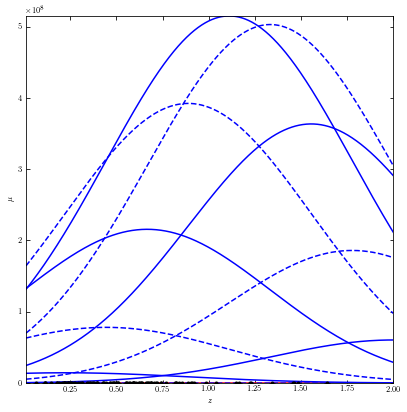

In [58]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z
from astroML.utils import split_samples

#------------------------------------------------------------
# Generate data
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0, dmu_0=1., dmu_1=0.)

cosmo = Cosmology()
z = np.linspace(0.01, 2, 1000)
mu_true = np.asarray(map(cosmo.mu, z))
(z_train, z_test), (mu_train, mu_test) = split_samples(z_sample, 
                                                       np.column_stack((mu_sample,dmu*0.00001)), 
                                                       [0.75, 0.25], random_state=0)
# Define our Gaussians
def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2) 

#------------------------------------------------------------
nGaussian = 10
basis_mu = np.linspace(0, 2, nGaussian)[:, None]
basis_sigma = 3 * (basis_mu[1] - basis_mu[0])
clf = BasisFunctionRegression('gaussian', mu=basis_mu, sigma=basis_sigma)
n_constraints = len(basis_mu) + 1

#fit the model
clf.fit(z_train[:, None], mu_train[:,0], mu_train[:,1])
mu_fit = clf.predict(z[:, None])

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    hspace=0.05, wspace=0.05)
ax = fig.add_subplot(111)
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
    

ax.plot(z, mu_fit, '-k',color='red')

ax.set_ylabel(r'$\mu$')

ax.set_xlabel(r'$z$')

#plot the gaussians
for i in range(nGaussian):
    if (clf.coef_[i] > 0.):
        ax.plot(z,clf.coef_[i]*gaussian_basis(z, basis_mu[i], basis_sigma),color='blue')
    else:
        ax.plot(z,-clf.coef_[i]*gaussian_basis(z, basis_mu[i], basis_sigma),color='blue',ls='--')





In [28]:
# Plot the results
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    hspace=0.05, wspace=0.05)
ax = fig.add_subplot(111)

# draw the fit to the data
i=0
mu_fit = np.zeros(len(z))
mu_fit_sample = np.zeros(len(z))
for i in range(nGaussians):
    mu_fit += coeff[i,0]*gaussian_basis(z, basis_mu[i], basis_sigma)
    mu_fit_sample += coeff[i,0]*gaussian_basis(z_sample, basis_mu[i], basis_sigma)
    

####--------------------------------------------------------
# THE RMS ERROR
err = np.sqrt(np.sum(((mu_fit_sample - mu_sample)** 2) / len(mu_sample)))

ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)


ax.set_xlim(0.01, 1.8)
ax.set_ylim(0.,100.)
ax.text(0.05, 0.95, 'Linear regression', ha='left', va='top',
                transform=ax.transAxes, fontsize=24)

#plot the gaussians
for i in range(nGaussians):
    if (coeff[i,0] > 0.):
        ax.plot(z,coeff[i,0]*gaussian_basis(z, basis_mu[i], basis_sigma),color='blue')
    else:
        ax.plot(z,-coeff[i,0]*gaussian_basis(z, basis_mu[i], basis_sigma),color='blue',ls='--')

ax.plot(z, mu_fit, '-k',color='red')

ax.set_ylabel(r'$\mu$')

ax.set_xlabel(r'$z$')


plt.show()

ValueError: shape of mu must match shape of X

##  Regularization <a id='regularization'></a>
[Go to top](#toc)

## Regularization

If we progressively increase the number of terms in the fit we reach a regime where we are overfitting the data (i.e. there are not enough degrees of freedom)

For cases where we are concerned with overfitting we can apply constraints (usually of smoothness, number of coefficients, size of coefficients).

> ($Y - M \theta)^T(Y- M \theta) + \lambda |\theta^T \theta|$

with $\lambda$ the regularization parameter

This leads to a solution for the parameters of the model

> $\theta = (M^T C^{-1} M + \lambda I)^{-1} (M^T C^{-1} Y)$

with $I$ the identity model

From the Bayesian perspective this is the same as applying a prior to the regression coefficients

> $p(\theta | I ) \propto \exp{\left(\frac{-(\lambda \theta^T \theta)}{2}\right)}$

which, when multiplied by the likelihood for regression, gives the same posterior as described above

##Ridge (Tikhonov) regularization

> $ |\theta |^2 < s$

penalty is on the sum of the squares of the regression coefficients

<center><img width=50%,  src="files/figures/ridge.png"></center>

This penalizes the size of the coefficients


##  Non-linear Regression with MCMC<a id='mcmc'></a>
[Go to top](#toc)

### Here MCMC stands for Markov Chain Monte Carlo

In statistics, Markov chain Monte Carlo (MCMC) methods comprise a class of algorithms for sampling from a probability distribution. By constructing a Markov chain that has the desired distribution as its equilibrium distribution, one can obtain a sample of the desired distribution by recording states from the chain. The more steps are included, the more closely the distribution of the sample matches the actual desired distribution. Various algorithms exist for constructing chains, including the Metropolis–Hastings algorithm. For more details,
see Chapter 5 in the textbook and 
https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo


##### Highly recommended supplemental background reading:
- [Thomas Wiecki: ``MCMC sampling for dummies by Thomas Wiecki"](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/)
  
##### For those who want to dive deep:
- [Andrieu et al. ``An Introduction to MCMC for Machine Learning" (includes a few pages of history)"](http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf)

**To find the maximum of a multi-dimensional function (e.g. likelihood or Bayesian posterior pdf)
we need a better method than the brute force grid search!**

For example, if we could generate a **sample** of  {𝜇𝑖,𝜎𝑖}  drawn from the posterior pdf for  𝜇  and  𝜎 , we could simply get posterior pdf for  𝜇  and  𝜎  by plotting histograms of  𝜇  and  𝜎  (similar to the above figure). As simple as that!

But how can we get such samples? **By using computers!** And MCMC :)

First we'll say a few words about Monte Carlo in general, and then we'll talk about a special kind of Monte Carlo called Markov Chain Monte Carlo.

### Definition of the general problem

What we want to be able to do is to evaluate multi-dimensional 
($\theta$ is a k-dimensional vector) integrals of the form 
$$ I = \int g(\theta) \, p(\theta) \, d\theta,$$
where for simplicity posterior pdf is described as
$$ p(\theta) \equiv p(M,\theta \,|\,D,I) \propto p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I). $$

For example:

1) **Marginalization**: if the first $P$ elements of $\theta$ are the sought
after model parameters, and the next $k-P$ parameters are nuisance 
parameters, when marginalizing $p(\theta)$ over nuisance parameters
we have $g(\theta) = 1$ and we integrate over space spanned by $k-P$ 
nuisance parameters. 

2) **Point estimates** for the posterior: if we want the mean of a model
parameter $\theta_m$, then $g(\theta) = \theta_m$ and we integrate over
all model parameters. 

3) **Model comparison**: here $g(\theta) = 1$ and we integrate over all model
parameters. 

## Monte Carlo Methods 

What you need is a computer that can generate (pseudo)random numbers and then you
solve a lot of hard problems. Let' start with an easy problem of one-dimensional
numerical integration.

Assume that you can generate a distribution of M random numbers $\theta_j$ uniformly sampled 
within the integration volume V. Then our interval can be evaluated as 
$$ I = \int g(\theta) \, p(\theta) \, d\theta = \frac{V}{M} \sum_{j=1}^M g(\theta_j) \, p(\theta_j).$$
    
Note that in 1-D we can write a similar expression 
$$ I = \int f(\theta) \, d\theta = \Delta \, \sum_{j=1}^M g(\theta_j) \, p(\theta_j).$$

where $ f(\theta) = g(\theta) \, p(\theta) $, and it is assumed that the values
$\theta_j$ are sampled on a regular grid with the step $\Delta = V/M$ ($V$ here is the
length of the sampling domain). This expression is the simplest example of
numerical integration ("rectangle rule", which amounts to approximating $f(\theta)$
by a piecewise constant function).

The reason why we expressed $f(\theta)$
as a product of $g(\theta)$ and $p(\theta)$ is that, as we will see shortly,
we can generate a sample drawn from $p(\theta)$ (instead of sampling on a 
regular grid), and this greatly improves the performance of numerical integration.

##  Markov Chain Monte Carlo

The modern version of the Markov Chain Monte Carlo method was invented in the late 1940s by Stanislaw Ulam, while he was working on nuclear weapons projects at the Los Alamos National Laboratory. The name Monte Carlo
was given to the method by Nick Metropolis, who then invented the Metropolis sampler, which evolved into
one of the most famous MCMC algorithms, the Metropolis-Hastings algorithm. 

Algorithms for generating Markov chains are numerous and greatly vary in complexity
and applicability. Many of the most important ideas were generated in physics, especially
in the context of statistical mechanics, thermodynamics, and quantum field theory.


### Example of non-linear regression: the age-color relation for asteroids

We will use age and color data for asteroid families shown in figure 1 from the paper "An age–colour relationship for main-belt S-complex asteroids" by Jedicke et al. (2004, Nature 429, 275), see http://www.astro.washington.edu/users/ivezic/Publications/jedicke.pdf

Given their y(x) data (see below), with errors in both x and y, we want to fit the following function

$$ 𝑦(𝑥)=𝑎+𝑏∗[1−𝑒𝑥𝑝(−(𝑥/𝑐)^𝑑)]. $$

We have a case of non-linear regression because y(x) depends non-linearly on the 
unknown coefficients c and d.
 
Important: here x is time, not log(time)! But in plots we'll use log(time) for x axis.

We want to: 

a) find the best-fit values and standard errors for parameters a, b, c and d. 

b) show the marginal distributions of fitted parameters. 

c) compare our best fit to the best fit from Jedicke et al.  


In [17]:
# These age and color data for asteroid families are taken
# from the paper Jedicke et al. (2004, Nature 429, 275) 

# Age is measured in 10^6 yrs (Myr)
# Log10(age) and error (of Log(Age))
logAge = np.asarray([3.398, 2.477, 3.398, 3.477, 3.301, 1.699, 2.699, 0.763,
         2.301, 3.079,  3.176, 0.398])
LageErr = np.asarray([0.087, 0.145, 0.174, 0.145, 0.109, 0.347, 0.174, 0.015,
          0.217, 0.145, 0.145, 0.434])
# SDSS principal asteroid color PC1 and its error (per family)
PC1 = np.asarray([0.620, 0.476, 0.523, 0.582, 0.460, 0.479, 0.432, 0.351, 
       0.427, 0.522, 0.532, 0.311])
PC1err = np.asarray([0.005, 0.015, 0.007, 0.011, 0.005, 0.032, 0.033, 0.047,
        0.021, 0.015, 0.022, 0.027])
# time/age on linear axes
age = 10**logAge
# and standard error propagation (although errors can be large)
ageErr = age * LageErr * np.log(10)

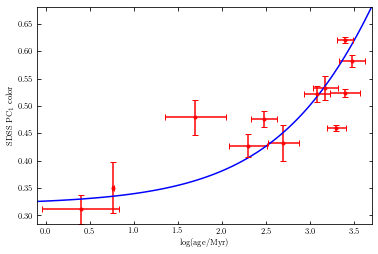

In [18]:
# let's take a quick look at the data to verify that it looks
# similar to fig. 1 from Jedicke et al. 
logT = np.linspace(-0.1, 3.7, 100)
time = np.power(10,logT)
# the best fit from Jedicke et al. 
color = 0.32 + 1.0*(1-np.exp(-(time/2.5e4)**0.5))
ax = plt.figure().add_subplot(111)
ax.set_xlabel("log(age/Myr)")
ax.set_ylabel("SDSS PC$_1$ color")
ax.plot(logT,color, c='blue')
ax.errorbar(logAge,PC1,xerr=LageErr, yerr=PC1err, color='r', 
             marker='.', ls='None', label='Observed')
plt.show() 

#### We will use pymc3 as the tool of choice to perform MCMC, see
[pymc3 docs](https://docs.pymc.io/)


I highly recommend to peruse this 
[excellent blog post by Jake VanderPlas](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/)


In [19]:
import pymc3 as pm
from astroML.plotting.mcmc import plot_mcmc 

In [20]:
# to make it look more generic (for future code reuse)
xObs = age
xErr = ageErr
yObs = PC1
yErr = PC1err

In [21]:
# three points to make:
# 1) note setting of the priors (for a, b, c and d)
# 2) note how error in x is handled with a latent variable
# 3) the actual model that is fit is given by AgeColor()
#      and it's super easy to change it! 
def MCMCasteroids(doXerror=True, draws=10000, tune=1000):
    with pm.Model():
        a = pm.Uniform('a', 0.1, 0.5)
        b = pm.Uniform('b', 0, 10)
        c = pm.Uniform('c', 0, 2000000)
        d = pm.Uniform('d', 0, 2)

        if doXerror:
            xLatent = pm.Normal('x', mu=xObs, sd=xErr, shape=xObs.shape)  
        else:
            xLatent = xObs
 
        y = pm.Normal('y', mu=AgeColor(xLatent, a, b, c, d), sd=yErr, observed=yObs)
        traces = pm.sample(draws=draws, tune=tune, return_inferencedata=False)

        return traces
    
# model to fit 
def AgeColor(t, a, b, c, d):
    """age-color relationship from Jedicke et al. (2004)"""
    return a + b*(1-np.exp(-(t/c)**d))

In [22]:
# obtain best-fit parameters using MCMC
traces = MCMCasteroids(True)
bf = pm.summary(traces)['mean']

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, d, c, b, a]
Sampling 4 chains: 100%|██████████| 44000/44000 [1:06:41<00:00, 11.00draws/s]
There were 6170 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7104690698577801, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5966 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6171 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6844333855117258, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5256 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.890415790347074, but should be close to 0.8. Try to increase the number

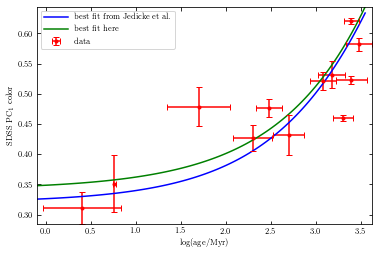

In [23]:
# let's take a look at the data and best-fit models 
logT = np.linspace(-0.1, 3.55, 100)
time = np.power(10,logT)

# fit from Jedicke
colorJedicke = 0.32 + 1.0*(1-np.exp(-(time/2.5e4)**0.5))
colorHere = AgeColor(time, bf['a'], bf['b'], bf['c'], bf['d']) 

# plot 
ax = plt.figure().add_subplot(111)
ax.set_xlabel("log(age/Myr)")
ax.set_ylabel("SDSS PC$_1$ color")
ax.plot(logT,colorJedicke, c='blue', label='best fit from Jedicke et al.')
ax.plot(logT,colorHere, c='green', label='best fit here')
ax.errorbar(logAge,PC1,xerr=LageErr, yerr=PC1err, color='r', marker='.', ls='None', label='data')
plt.legend()
plt.show() 

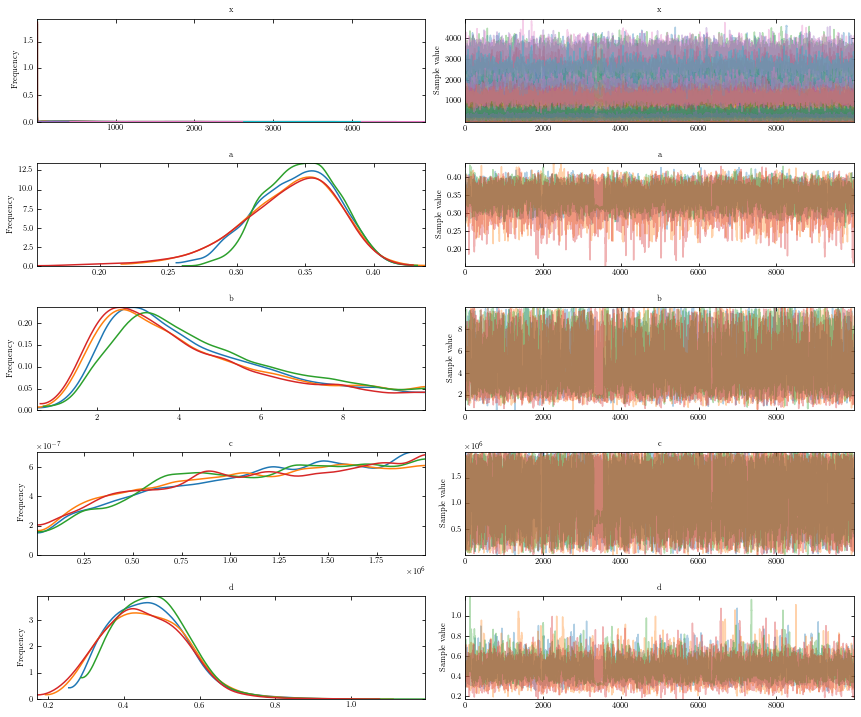

In [24]:
# the so-called traces for model parameters:
plot = pm.traceplot(traces)

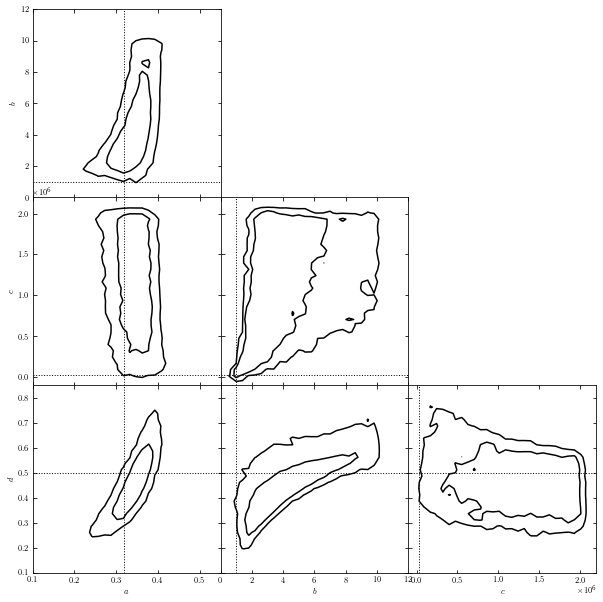

In [25]:
# and a pretty so-called corner plot:
labels = ['$a$', '$b$', '$c$', '$d$']
limits = [(0.1, 0.55), (0.0, 12), (-100000,2200000), (0.1, 0.85)]
jedicke = [0.32, 1.0, 25000, 0.5]


# Plot the results
fig = plt.figure(figsize=(9, 9))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc([traces[i] for i in ['a', 'b', 'c', 'd']],
          labels=labels, limits=limits,
          true_values=jedicke, fig=fig, bins=30, colors='k')

plt.show()

In [26]:
import corner

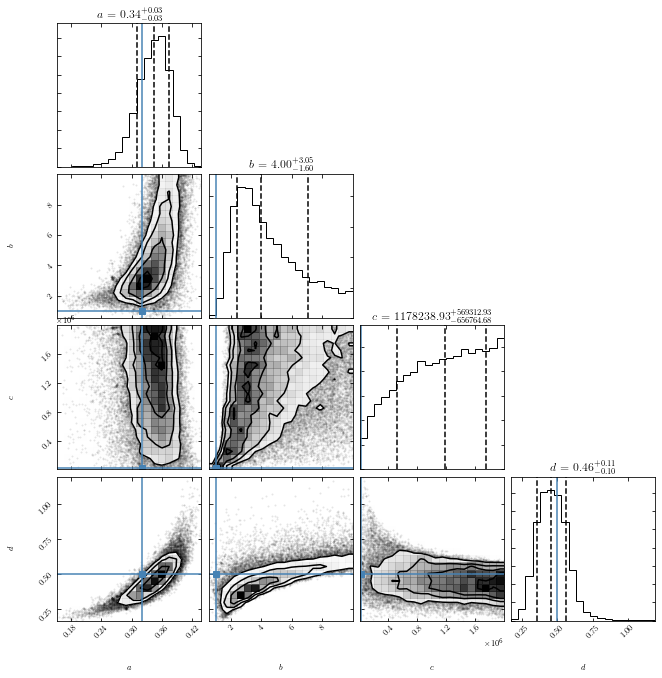

In [27]:
Ls = [r"$a$", r"$b$", r"$c$", r"$d$"] 
samples = np.vstack([traces[i] for i in ['a', 'b', 'c', 'd']]).T
corner.corner(samples, truths=jedicke, labels=Ls, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12});

### Instead of using pymc3, we will solve a similar problem with much more light-weight emcee tool during our afternoon activity later today

In [28]:
import emcee